In [69]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [70]:
symbol = "AAL"
ticker = yf.Ticker(symbol)

In [71]:
ticker.info['longBusinessSummary']

'American Airlines Group Inc., through its subsidiaries, operates as a network air carrier. The company provides scheduled air transportation services for passengers and cargo through its hubs in Charlotte, Chicago, Dallas/Fort Worth, Los Angeles, Miami, New York, Philadelphia, Phoenix, and Washington, D.C., as well as through partner gateways in London, Doha, Madrid, Seattle/Tacoma, Sydney, and Tokyo. As of December 31, 2022, it operated a mainline fleet of 925 aircraft. The company was formerly known as AMR Corporation and changed its name to American Airlines Group Inc. in December 2013. American Airlines Group Inc. was founded in 1926 and is headquartered in Fort Worth, Texas.'

In [72]:
df = ticker.history(period="max")

In [73]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-09-27 00:00:00-04:00,19.844708,20.174668,18.006363,18.194910,961200,0.0,0.0
2005-09-28 00:00:00-04:00,18.194908,19.354481,18.100635,19.326199,5747900,0.0,0.0
2005-09-29 00:00:00-04:00,19.231930,19.401624,18.949108,19.052809,1078200,0.0,0.0
2005-09-30 00:00:00-04:00,19.099945,19.844710,19.024526,19.807001,3123300,0.0,0.0
2005-10-03 00:00:00-04:00,19.703297,20.504627,19.703297,20.268942,1057900,0.0,0.0


In [74]:
print(f"Length: {len(df)}")

Length: 4461


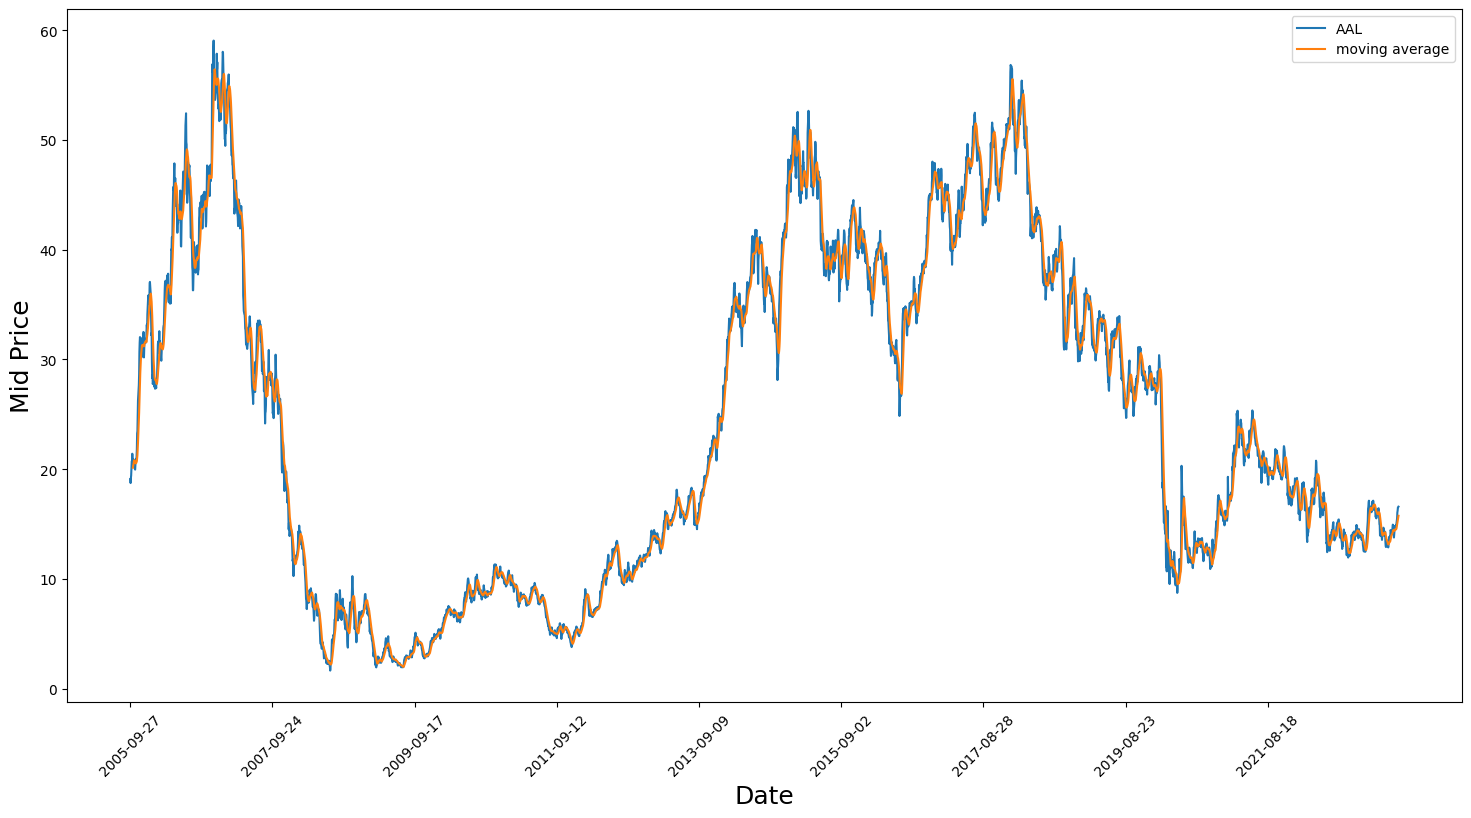

In [75]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0, label = symbol)
plt.xticks(range(0,df.shape[0],500),df.index.date[::500],rotation=45)

movingAverage = ((df["Low"] + df["High"])/2.0).rolling(window=10).mean()
plt.plot(range(df.shape[0]), movingAverage, label="moving average")

plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.legend()
plt.show()

In [76]:
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [77]:
# split = int(len(mid_prices) * 0.7)
split = 3000
train_data = mid_prices[:split]
test_data = mid_prices[split:]

In [78]:
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [79]:
scaler = MinMaxScaler()

smoothing_window_size = 1000
for di in range(0,2000,smoothing_window_size):
    train_data[di:di+smoothing_window_size,:] = scaler.fit_transform(train_data[di:di+smoothing_window_size,:])

train_data[di+smoothing_window_size:,:] = scaler.fit_transform(train_data[di+smoothing_window_size:,:])

In [80]:
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

data = np.append(train_data, test_data)

In [81]:
from sklearn.model_selection import train_test_split

X = []
y = []

for i in range(60, len(data)-60):
  X.append(data[i-60:i])
  y.append(data[i])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = False)

In [82]:
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

# Using LSTMs


In [83]:
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()

In [84]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))
regressor.add(Dense(units = 1))

In [85]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [86]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
91/91 [==============================] - 10s 13ms/step - loss: 0.0277
Epoch 2/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0087
Epoch 3/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0077
Epoch 4/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0078
Epoch 5/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 6/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0064
Epoch 7/100
91/91 [==============================] - 1s 16ms/step - loss: 0.0061
Epoch 8/100
91/91 [==============================] - 2s 17ms/step - loss: 0.0056
Epoch 9/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0052
Epoch 10/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0056
Epoch 11/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0049
Epoch 12/100
91/91 [==============================] - 1s 13ms/step - loss: 0.0046
Epoch 13/100
91/91 [====

In [87]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

45/45 [==============================] - 2s 7ms/step


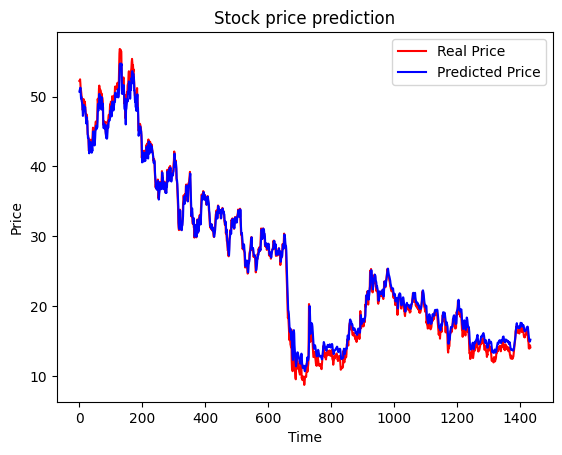

In [88]:
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color = 'red', label = 'Real Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Price')
plt.title('Stock price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [95]:
from keras.models import load_model
regressor.save("model")
print("Saved model to disk")

Saved model to disk


In [103]:
!zip -r ./model.zip ./model/

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 91%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 93%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model/variables/variables.index (deflated 66%)
  adding: model/fingerprint.pb (stored 0%)


In [96]:
regressor = load_model("model")
print("Model loaded from disk")

Model loaded from disk


In [97]:
symbol = "MSFT"
ticker = yf.Ticker(symbol)
df = ticker.history(period="max")
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
data = (high_prices+low_prices)/2.0
data = data.reshape(-1,1)
data = scaler.transform(data).reshape(-1)

In [98]:
df.shape

(9392, 7)

In [99]:
X = []
y = []

for i in range(60, len(data)-60):
  X.append(data[i-60:i])
  y.append(data[i])

X, y = np.array(X), np.array(y)

In [100]:
predicted_stock_price = regressor.predict(X)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

290/290 [==============================] - 3s 6ms/step


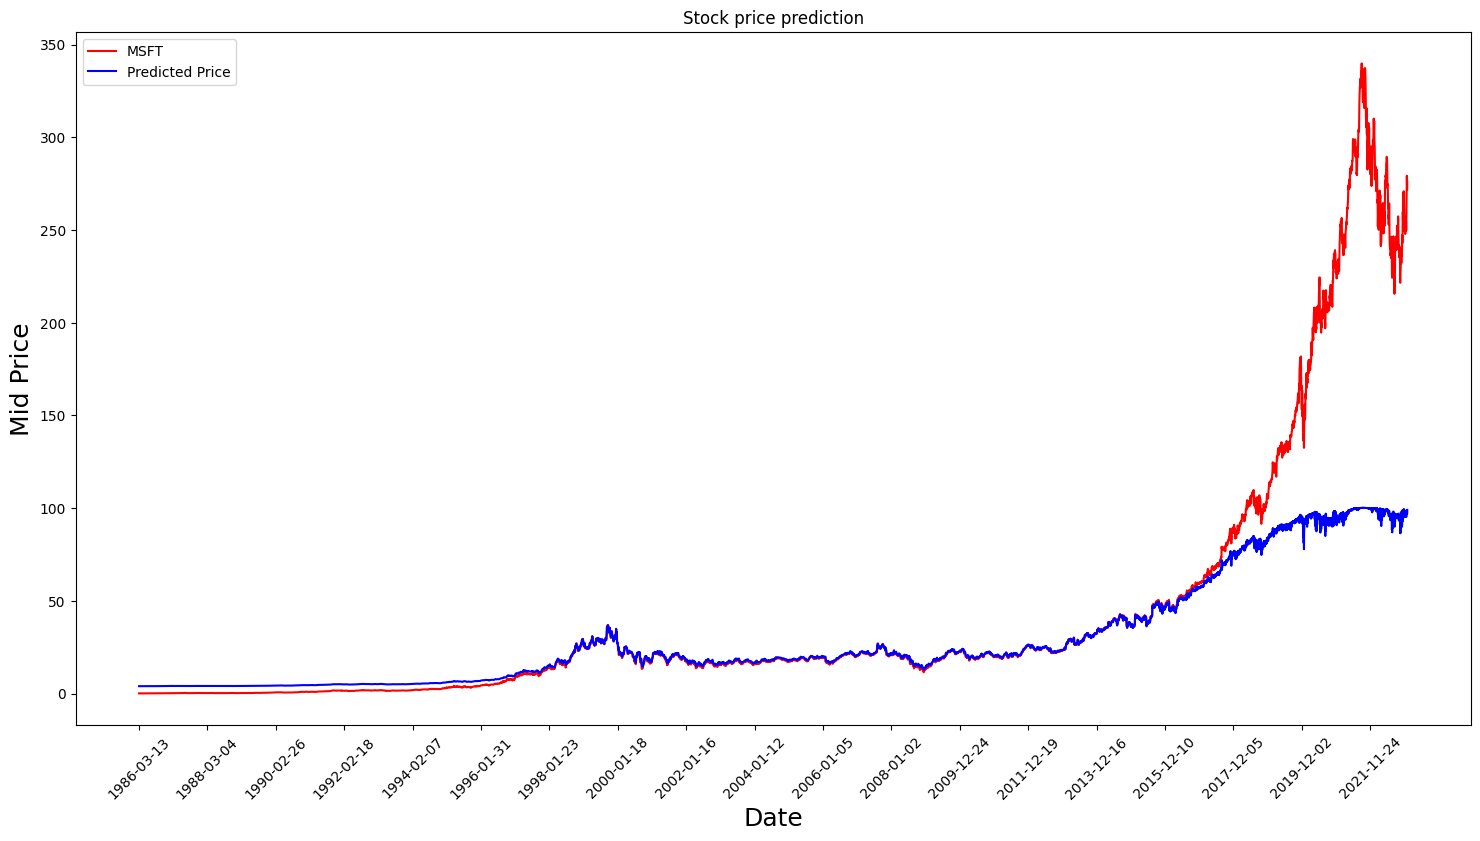

In [101]:
plt.figure(figsize = (18,9))
plt.plot(scaler.inverse_transform(y.reshape(-1, 1)), color = 'red', label = symbol)
plt.xticks(range(0,len(y),500),df.index.date[::500],rotation=45)
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Price')
plt.title('Stock price prediction')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.legend()
plt.show()

In [102]:
loss = regressor.evaluate(X, y, verbose=0)
print("%s: %.2f" % (regressor.metrics_names[0], loss))

loss: 1.57


# Using Support Vector Regression

In [ ]:
# Use sklearn support vector regression to predict our data:
import numpy as np
from sklearn.svm import SVR

dates = dates_df['Date'].values
prices = df['Close'].values

#Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), ))

train_dates = dates[:split]
test_dates = dates[split:]

train_prices = dates[:split]
test_prices = dates[split:]

svr_rbf = SVR(kernel='rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(train_dates, train_prices)

plt.figure(figsize = (12,6))
plt.plot(test_dates, test_prices, color= 'black', label= 'Data')
plt.plot(test_org_dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()